In [1]:
import matplotlib.pyplot as plt
from pyspark.sql import functions as F
import matplotlib.mlab as mlab
from matplotlib.ticker import MaxNLocator
from pyspark.ml.feature import VectorAssembler
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
from pyspark.ml.feature import MaxAbsScaler
from pyspark.ml.clustering import KMeans

%matplotlib inline is not supported in Databricks.
You can display matplotlib figures using display(). For an example, see https://docs.databricks.com/user-guide/visualizations/matplotlib-and-ggplot.html

In [2]:
dfTwitter = spark.read.json('/FileStore/tables/TwitterData.json')
dfStock = spark.read.format("csv").option("header", "true").load("/FileStore/tables/*.csv")

dfAvgSent = dfTwitter.groupby('tweet_hour', 'company').agg(F.mean('sentiment'), F.mean('followers_count'))
dfAvgSent = dfAvgSent.withColumnRenamed('company', 'comp')
dfAvgStock = dfStock.groupby('stock_hour', 'company').agg(F.mean('close'), F.mean('volume'))

dfJoin = dfAvgSent.join(dfAvgStock, (dfAvgSent.comp == dfAvgStock.company) & (dfAvgSent.tweet_hour == dfAvgStock.stock_hour+5))
dfJoin = dfJoin.withColumnRenamed("avg(sentiment)","avg-sentiment")
dfJoin = dfJoin.withColumnRenamed("avg(close)","avg-close")
dfJoin = dfJoin.withColumnRenamed("avg(volume)","avg-volume")
dfJoin = dfJoin.withColumnRenamed("avg(followers_count)","avg-followers")
dfJoin.show()

+----------+---------+--------------------+------------------+----------+---------+------------------+------------------+
tweet_hour| comp| avg-sentiment| avg-followers|stock_hour| company| avg-close| avg-volume|
+----------+---------+--------------------+------------------+----------+---------+------------------+------------------+
 10151818| NETFLIX|-0.09271767875921039|1746.7666482453717| 10151813| NETFLIX| 336.1357083333333| 95428.83333333333|
 10191819| AMAZON| 0.16813951026250007| 6077.93262987013| 10191814| AMAZON|1760.0050833333332|42773.333333333336|
 10161821| SNAPCHAT| 0.05182993606924914|2404.6233611442194| 10161816| SNAPCHAT| 7.25| 1243619.0|
 10151816| NETFLIX|-0.07514151537512723| 5477.729020394517| 10151811| NETFLIX|333.49904166666664|127720.83333333333|
 10151820| GOOGLE| 0.0413293485387727| 9035.437435721631| 10151815| GOOGLE|1108.2241583333332|15962.166666666666|
 10191814| SNAPCHAT| 0.05638158606736857|1874.1263157894737| 10191809| SNAPCHAT| 6.916000000000001| 418241.0|
 10161817| AMAZON| 0.17115129035362472| 5588.364644970414| 10161812| AMAZON|1790.0160499999995|42391.916666666664|
 10161815| NETFLIX|-0.07969931751544584|1474.3531320999675| 10161810| NETFLIX| 335.6295166666667|211540.16666666666|
 10171815| SNAPCHAT| 0.05936671187504906|12607.562868369352| 10171810| SNAPCHAT| 7.025641666666666| 400381.1666666667|
 10171819| NETFLIX|-0.03019385011171244| 2434.23238566131| 10171814| NETFLIX|359.71187499999996| 268221.3333333333|
 10151816| FACEBOOK| 0.0829153378749519| 8589.73570019724| 10151811| FACEBOOK|154.96449166666667|199680.08333333334|
 10161820|MICROSOFT|-0.01882265850817...|22349.116670647243| 10161815|MICROSOFT|110.77088333333332| 430116.75|
 10181817| FACEBOOK| 0.04603225031068867| 5341.205856515373| 10181812| FACEBOOK|155.24916666666667|196831.33333333334|
 10161821| AMAZON| 0.16737116618806488| 5648.99304750869| 10161816| AMAZON| 1819.9| 422992.0|
 10181814| NETFLIX|-0.05580422243104...|2044.4039709812905| 10181809| NETFLIX| 359.07| 423651.8|
 10161816| SNAPCHAT|0.044347740083109384| 6079.18905950096| 10161811| SNAPCHAT| 7.129166666666666| 369565.0833333333|
 10171816| NETFLIX|-0.02698725960905734|2643.9734640899915| 10171811| NETFLIX|366.51182500000004| 304385.75|
 10171818| SNAPCHAT| 0.04110904551941123| 4853.074781225139| 10171813| SNAPCHAT| 7.057250000000001| 124399.25|
 10181821| NETFLIX| -0.0677279977321253| 2205.965579710145| 10181816| NETFLIX| 346.7981| 468953.0|
 10171816| GOOGLE| 0.09027756074533166| 7833.36797188755| 10171811| GOOGLE|1123.0080083333335| 16634.0|
+----------+---------+--------------------+------------------+----------+---------+------------------+------------------+
only showing top 20 rows

In [3]:
from pyspark.ml.feature import VectorAssembler
dfJoin1 = dfJoin.select("avg-sentiment","avg-followers","avg-volume")
inputFeatures = ["avg-sentiment","avg-followers","avg-volume"]
assembler = VectorAssembler(inputCols=inputFeatures, outputCol="features")
dfJoin2 = assembler.transform(dfJoin1)

In [4]:
# Scaling features
scaler = MaxAbsScaler(inputCol="features", outputCol="scaledFeatures")
scalerModel = scaler.fit(dfJoin2)
scaledData = scalerModel.transform(dfJoin2)
scaledData.select("features", "scaledFeatures").show()

+--------------------+--------------------+
 features| scaledFeatures|
+--------------------+--------------------+
[-0.0927176787592...|[-0.4221603565376...|
[0.16813951026250...|[0.76556959309579...|
[0.05182993606924...|[0.23599107077669...|
[-0.0751415153751...|[-0.3421329065400...|
[0.04132934853877...|[0.18817999704141...|
[0.05638158606736...|[0.25671555624435...|
[0.17115129035362...|[0.77928277243869...|
[-0.0796993175154...|[-0.3628854038236...|
[0.05936671187504...|[0.27030737381511...|
[-0.0301938501117...|[-0.1374780591898...|
[0.08291533787495...|[0.37752852603903...|
[-0.0188226585081...|[-0.0857029676879...|
[0.04603225031068...|[0.20959315918441...|
[0.16737116618806...|[0.76207118359344...|
[-0.0558042224310...|[-0.2540867152096...|
[0.04434774008310...|[0.20192327952626...|
[-0.0269872596090...|[-0.1228778728177...|
[0.04110904551941...|[0.18717691755922...|
[-0.0677279977321...|[-0.3083778202043...|
[0.09027756074533...|[0.41105005799995...|
+--------------------+--------------------+
only showing top 20 rows

In [5]:
#Elbow method
import numpy as np
cost = np.zeros(10)
for k in range(2,10):
    kmeans = KMeans().setK(k).setFeaturesCol("scaledFeatures").setPredictionCol("prediction").setMaxIter(1).setSeed(1)
    model = kmeans.fit(scaledData)
    cost[k] = model.computeCost(scaledData)

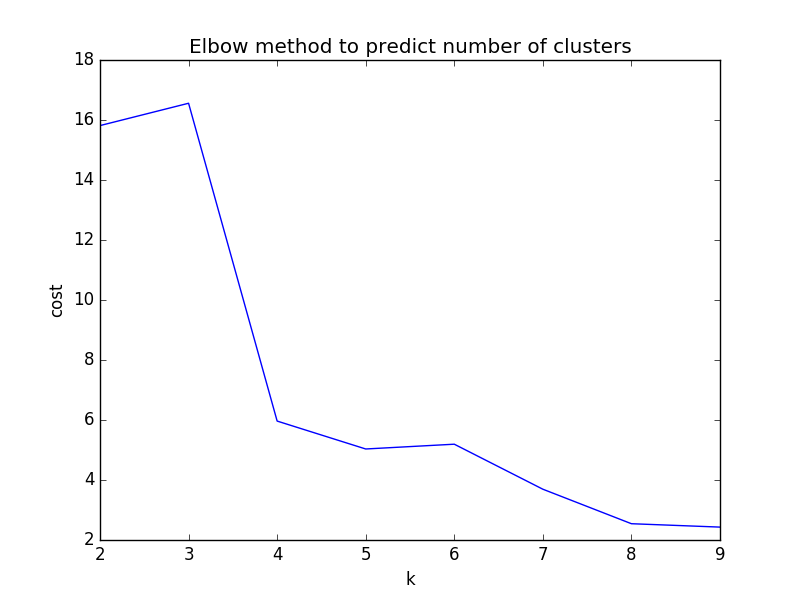

In [6]:
#Plot of elbow method
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,10),cost[2:10])
ax.set(title='Elbow method to predict number of clusters')
ax.set_xlabel('k')
ax.set_ylabel('cost')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.show()
display(fig)

In [7]:
#Kmeans algorithm
kmeans = KMeans().setK(8).setFeaturesCol("scaledFeatures").setPredictionCol("prediction").setMaxIter(10).setSeed(1)
model = kmeans.fit(scaledData)
output_df = model.transform(scaledData)
display(output_df.take(5))
groupedByRegion = output_df.groupby(output_df['prediction']).count()
display(groupedByRegion)

prediction,count
1,40
6,40
3,90
5,38
4,3
7,1
2,20
0,2


In [8]:
df_pred = output_df.select('avg-sentiment','avg-followers','avg-volume','prediction')
df_pandas = df_pred.toPandas()

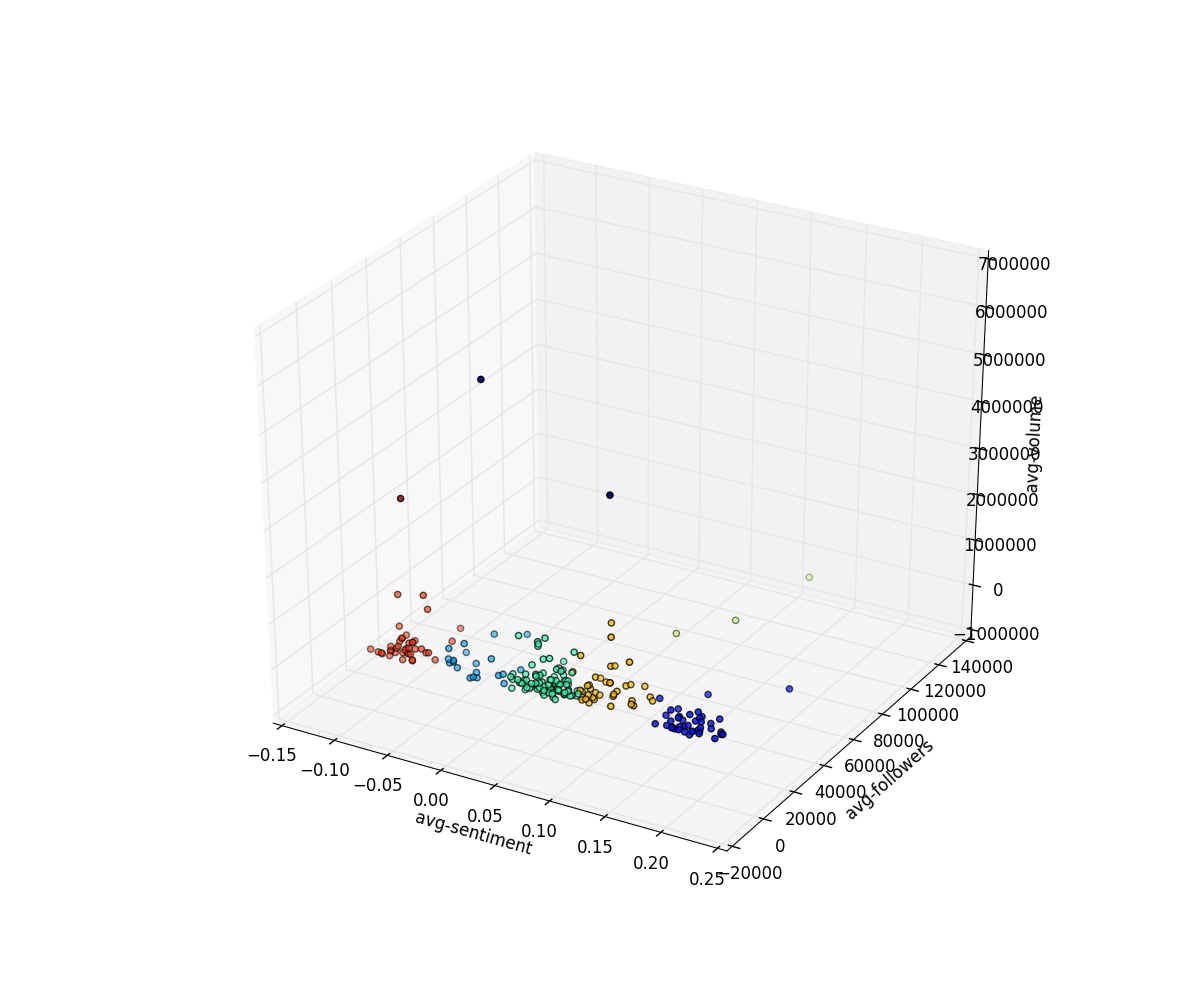

In [9]:
image = plt.figure(figsize=(12,10)).gca(projection='3d')
image.scatter(df_pandas["avg-sentiment"], df_pandas["avg-followers"], df_pandas["avg-volume"], c=df_pandas.prediction)
image.set_xlabel('avg-sentiment')
image.set_ylabel('avg-followers')
image.set_zlabel('avg-volume')
plt.show()
display()